In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use("ggplot")
%matplotlib inline

In [39]:
def get_data(symbol):

    # Technical Indicators
    ti = TechIndicators(key='4BTFICZGTPWZRRQS', output_format='pandas')
    sma, _ = ti.get_sma(symbol=symbol, interval='daily')
    wma, _ = ti.get_wma(symbol=symbol, interval='daily')
    ema, _ = ti.get_ema(symbol=symbol, interval='daily')
    macd, _ = ti.get_macd(symbol=symbol, interval='daily')
#     stoch, _ = ti.get_stoch(symbol=symbol, interval='daily')
#     rsi, _ = ti.get_rsi(symbol=symbol, interval='daily')
#     adx, _ = ti.get_adx(symbol=symbol, interval='daily')
#     cci, _ = ti.get_cci(symbol=symbol, interval='daily')
#     aroon, _ = ti.get_aroon(symbol=symbol, interval='daily')
#     bbands, _ = ti.get_bbands(symbol='SPX', interval='daily')
#     ad, _ = ti.get_ad(symbol='SPX', interval='daily')
#     obv, _ = ti.get_obv(symbol='SPX', interval='daily')
#     mom, _ = ti.get_mom(symbol='SPX', interval='daily')
#     willr, _ = ti.get_willr(symbol='SPX', interval='daily')
    tech_ind = pd.concat([sma, ema, macd, stoch], axis=1)

    ts = TimeSeries(key='4BTFICZGTPWZRRQS', output_format='pandas')
    close = ts.get_daily(symbol=symbol, outputsize='full')[0]['4. close']   # compact/full
    direction = (close > close.shift()).astype(int)
    target = direction.shift(-1).fillna(0).astype(int)
    target.name = 'target'

    data = pd.concat([tech_ind, close, target], axis=1)

    return data


def get_indicators(data, n):

    hh = data['2. high'].rolling(n).max()
    ll = data['3. low'].rolling(n).min()
    up, dw = data['4. close'].diff(), -data['4. close'].diff()
    up[up<0], dw[dw<0] = 0, 0
    macd = data['4. close'].ewm(12).mean() - data['4. close'].ewm(26).mean()
    macd_signal = macd.ewm(9).mean()
    tp = (data['2. high'] + data['3. low'] + data['4. close']) / 3
    tp_ma = tp.rolling(n).mean()
    indicators = pd.DataFrame(data=0, index=data.index,
                              columns=['sma', 'ema', 'macd',
#                                        'momentum'
#                                        'sto_k', 'sto_d', 'rsi',
#                                         'lw_r', 'a/d', 'cci'
                                      ])
    indicators['sma'] = data['4. close'].rolling(10).mean()
    indicators['ema'] = data['4. close'].ewm(10).mean()
#     indicators['momentum'] = data['close'] - data['close'].shift(n)
#     indicators['sto_k'] = (data['close'] - ll) / (hh - ll) * 100
#     indicators['sto_d'] = indicators['sto_k'].rolling(n).mean()
#     indicators['rsi'] = 100 - 100 / (1 + up.rolling(14).mean() / dw.rolling(14).mean())
    indicators['macd'] = macd - macd_signal
#     indicators['lw_r'] = (hh - data['close']) / (hh - ll) * 100
#     indicators['a/d'] = (data['high'] - data['close'].shift()) / (data['high'] - data['low'])
#     indicators['cci'] = (tp - tp_ma) / (0.015 * tp.rolling(n).apply(lambda x: np.std(x)))

    return indicators


def rebalance(unbalanced_data):

    # Separate majority and minority classes
    data_minority = unbalanced_data[unbalanced_data.target==0]
    data_majority = unbalanced_data[unbalanced_data.target==1]

    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=5)

    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])

    data_upsampled.sort_index(inplace=True)

    # Display new class counts
    data_upsampled.target.value_counts()

    return data_upsampled


def normalize(x):

    scaler = StandardScaler()
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)

    return x_norm


def scores(models, X, y):

    for model in models:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        auc = roc_auc_score(y, y_pred)
        print("Accuracy Score: {0:0.2f} %".format(acc * 100))
        print("F1 Score: {0:0.4f}".format(f1))
        print("Area Under ROC Curve Score: {0:0.4f}".format(auc))

In [54]:
print(sklearn.__version__)

0.18.1


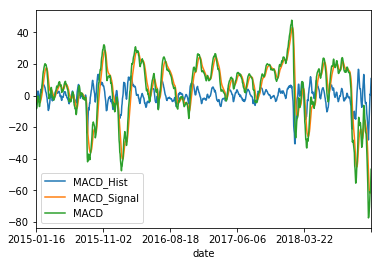

In [18]:
macd.tail(1000).plot()

In [36]:
ts = TimeSeries(key='4BTFICZGTPWZRRQS', output_format='pandas')
ts.get_daily(symbol='AAPL', outputsize='full')[0].tail(252)['4. close']

date
2017-06-06    154.45
2017-06-07    155.37
2017-06-08    154.99
2017-06-09    148.98
2017-06-12    145.42
2017-06-13    146.59
2017-06-14    145.16
2017-06-15    144.29
2017-06-16    142.27
2017-06-19    146.34
2017-06-20    145.01
2017-06-21    145.87
2017-06-22    145.63
2017-06-23    146.28
2017-06-26    145.82
2017-06-27    143.73
2017-06-28    145.83
2017-06-29    143.68
2017-06-30    144.02
2017-07-03    143.50
2017-07-05    144.09
2017-07-06    142.73
2017-07-07    144.18
2017-07-10    145.06
2017-07-11    145.53
2017-07-12    145.74
2017-07-13    147.77
2017-07-14    149.04
2017-07-17    149.56
2017-07-18    150.08
               ...  
2018-11-21    176.78
2018-11-23    172.29
2018-11-26    174.62
2018-11-27    174.24
2018-11-28    180.94
2018-11-29    179.55
2018-11-30    178.58
2018-12-03    184.82
2018-12-04    176.69
2018-12-06    174.72
2018-12-07    168.49
2018-12-10    169.60
2018-12-11    168.63
2018-12-12    169.10
2018-12-13    170.95
2018-12-14    165.48
2018-12-

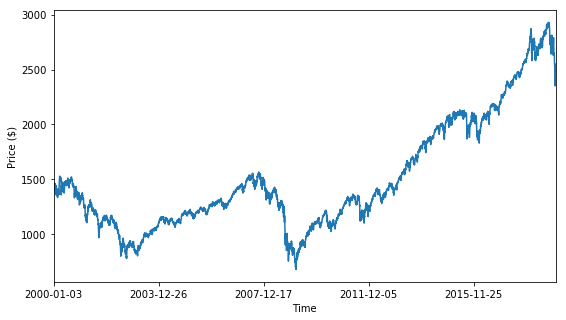

In [40]:
# Part 1:

symbol = 'SPX'  # S&P500
data = get_data(symbol)
data.tail(10)
data.describe()
ax = data['4. close'].plot(figsize=(9, 5))
ax.set_ylabel("Price ($)")
ax.set_xlabel("Time")
plt.show()

In [41]:
# Part 2:

data_train = data['2011-01-01':'2017-01-01']
data_train = rebalance(data_train)
y = data_train.target
X = data_train.drop('target', axis=1)
X = normalize(X)
data_val = data['2017-01-01':]
y_val = data_val.target
X_val = data_val.drop('target', axis=1)
X_val = normalize(X_val)

In [107]:
# Part 3"
# Machine Learning

# Train test split
import sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6)

models = [GaussianNB(priors=None),
          SVC(random_state=5),
          RandomForestClassifier(random_state=5),
          MLPClassifier(random_state=5)]

for model in models:
    model.fit(X_train, y_train)

scores(models, X_test, y_test)

Accuracy Score: 50.92 %
F1 Score: 0.3383
Area Under ROC Curve Score: 0.5046
Accuracy Score: 52.40 %
F1 Score: 0.4163
Area Under ROC Curve Score: 0.5208
Accuracy Score: 69.37 %
F1 Score: 0.6556
Area Under ROC Curve Score: 0.6919
Accuracy Score: 49.82 %
F1 Score: 0.4426
Area Under ROC Curve Score: 0.4965


In [112]:
models

[GaussianNB(priors=None),
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=5, shrinking=True,
   tol=0.001, verbose=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_jobs=1, oob_score=False, random_state=5,
             verbose=0, warm_start=False),
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(100,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=200, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=5, shuffle=True,
        solver='adam', t

In [130]:
# Trying to fix the bracket issue:
grid_data = [
              # Model 1 - GaussianNB(priors=None)'s parameters:
              {'priors': [None]},
    
              # Model 2 - SVC's parameters:
              {'kernel': ['rbf', 'sigmoid'], 'C': [0.1, 1, 10, 100], 'random_state': [5]},
    
              # Model 3 - RandomForestClassifier's parameters:
              {'n_estimators': [10, 50, 100],
               'criterion': ['gini', 'entropy'],
               'max_depth': [None, 10, 50, 100],
               'min_samples_split': [2, 5, 10],
               'random_state': [5]},
    
              # Model 4 - MLPClassifier's parameters:
              {'hidden_layer_sizes': [10, 50, 100],
               'activation': ['identity', 'logistic', 'tanh', 'relu'],
               'solver': ['lbfgs', 'sgd', 'adam'],
               'learning_rate': ['constant', 'invscaling', 'adaptive'],
               'max_iter': [200, 400, 800],
               'random_state': [5]}]

models_grid = list()

In [131]:
# Og
# grid_data = [[{'kernel': ['poly'], 'degree': [1, 2, 3, 4], 'C': [0.1, 1, 10, 100], 'random_state': [5]},
#               {'kernel': ['rbf', 'sigmoid'], 'C': [0.1, 1, 10, 100], 'random_state': [5]}],
#               {'n_estimators': [10, 50, 100],
#                'criterion': ['gini', 'entropy'],
#                'max_depth': [None, 10, 50, 100],
#                'min_samples_split': [2, 5, 10],
#                'random_state': [5]},
#               {'hidden_layer_sizes': [10, 50, 100],
#                'activation': ['identity', 'logistic', 'tanh', 'relu'],
#                'solver': ['lbfgs', 'sgd', 'adam'],
#                'learning_rate': ['constant', 'invscaling', 'adaptive'],
#                'max_iter': [200, 400, 800],
#                'random_state': [5]}]

In [132]:
for i in range(3):
    print ("Model{}".format(i))
    grid = GridSearchCV(models[i], grid_data[i], scoring='f1').fit(X_train, y_train)
    print(grid.best_params_)
    model = grid.best_estimator_
    models_grid.append(model)
scores(models_grid, X_test, y_test)

Model0
{'priors': None}
Model1
{'random_state': 5, 'C': 100, 'kernel': 'rbf'}
Model2
{'min_samples_split': 5, 'max_depth': None, 'random_state': 5, 'n_estimators': 100, 'criterion': 'entropy'}
Accuracy Score: 50.92 %
F1 Score: 0.3383
Area Under ROC Curve Score: 0.5046
Accuracy Score: 57.93 %
F1 Score: 0.5128
Area Under ROC Curve Score: 0.5770
Accuracy Score: 70.11 %
F1 Score: 0.6747
Area Under ROC Curve Score: 0.6998


In [133]:
# Validation data
scores(models_grid, X_val, y_val)

Accuracy Score: 46.25 %
F1 Score: 0.3524
Area Under ROC Curve Score: 0.4829
Accuracy Score: 50.20 %
F1 Score: 0.5097
Area Under ROC Curve Score: 0.5050
Accuracy Score: 50.59 %
F1 Score: 0.5915
Area Under ROC Curve Score: 0.4905


In [144]:
print ("Model 1: ", models_grid[0])
print ("Model 2: ", models_grid[1])
print ("Model 3: ", models_grid[2])
models_grid[3]

Model 1:  GaussianNB(priors=None)
Model 2:  SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=5, shrinking=True,
  tol=0.001, verbose=False)
Model 3:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=5,
            verbose=0, warm_start=False)


IndexError: list index out of range

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=5,
            verbose=0, warm_start=False)

Testing Model1...


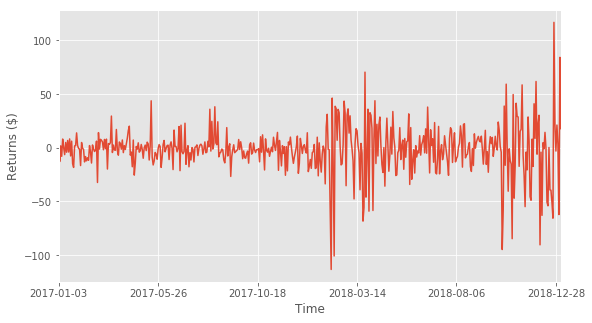

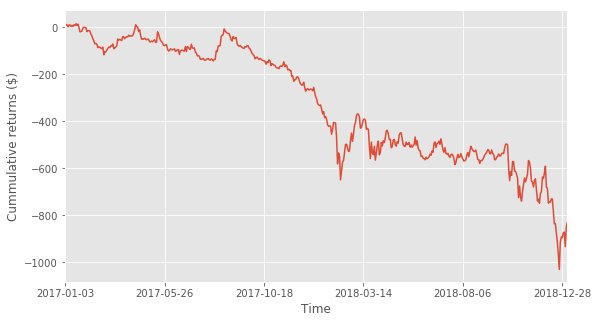

Testing Model2...


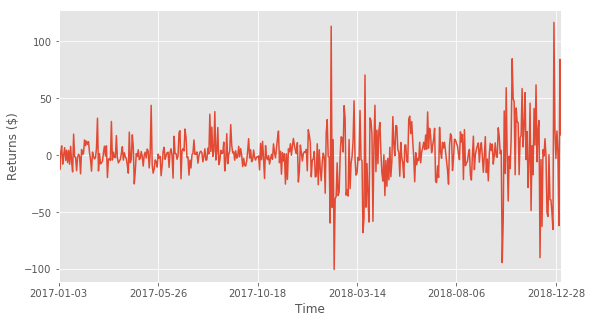

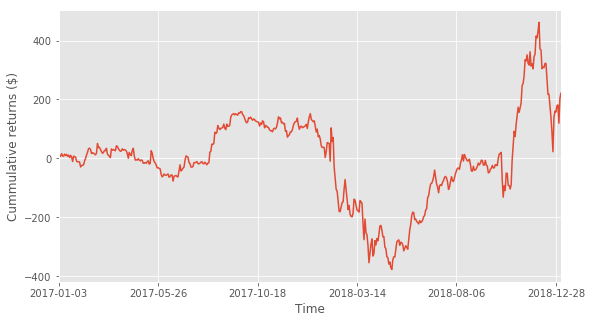

Testing Model3...


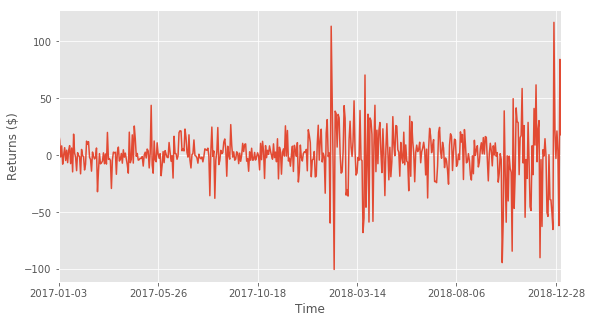

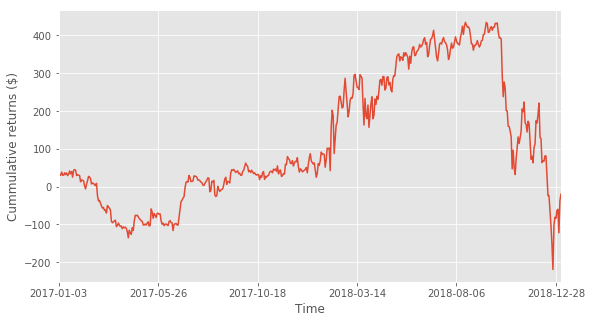

In [152]:
# Trading system
for i in range(3):
    print ("======================================================================")
    print ("Testing Model{}...".format(i+1))
    rf_model = models_grid[i]
    y_pred = rf_model.predict(X_val)
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data['4. close'].diff()
    data_returns = data_returns[X_val.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum()
    equity = model_returns.sum()
    start_close = data["4. close"][X_val.index[0]]
    performance = equity / start_close * 100
    ax = model_returns.plot(figsize=(9, 5))
    ax.set_ylabel("Returns ($)")
    ax.set_xlabel("Time")
    plt.show()
    ax = model_cum.plot(figsize=(9, 5))
    ax.set_ylabel("Cummulative returns ($)")
    ax.set_xlabel("Time")
    plt.show()

In [ ]:
random_forest(para1_ = , para2_ = )

In [156]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,

In [157]:
mask

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1,
        1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1,  1,
       -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,
       -1, -1,  1, -1, -1